# Understanding US Black Friday Shopping Trends with Spatial Analytics

Disclaimer: To reproduce the analysis performed in these notebooks you need a subscription to this dataset

https://carto.com/spatial-data-catalog/browser/dataset/sg_patterns_a66a8e6d/

### Outline
* Identifying hotspots
* Selecting relevant POI categories
* Comparing cities across years
* Case study: Walmart

We will focus on the city of Chicago


## 1. Identifying hotspots

In [41]:
import pandas as pd, numpy as np, seaborn as sns
from matplotlib import pyplot as plt
from google.cloud import bigquery

from shapely.geometry import box, Polygon
import h3
import geopandas as gpd

from cartoframes.viz import Map, Layer, size_bins_style, color_bins_style, color_continuous_style, basic_style
from cartoframes.auth import set_default_credentials
from dotenv import load_dotenv
load_dotenv("/Users/juanluis/Documents/credentials/env.txt")
set_default_credentials("/Users/juanluis/Documents/credentials/carto_creds_publications.json")

#### The data: Monthly / weekly patterns

In [21]:
bq_client = bigquery.Client()
sample = bq_client.query("""SELECT * 
                            FROM `cartodb-on-gcp-datascience.juanluis.safegraph_blackfriday_chicago` 
                            WHERE raw_visit_counts is not null LIMIT 100""").result().to_dataframe()

In [23]:
sample.iloc[0]

do_date                                                             2020-12-01
placekey                                                   zzw-222@5pv-yw2-p35
parent_placekey                                                           None
location_name                                                       Ford Motor
safegraph_brand_ids                                                       None
brands                                                                    None
latitude                                                             41.667418
longitude                                                           -87.548591
street_address                                          12525 S Carondolet Ave
city                                                                   Chicago
region                                                                      IL
postal_code                                                              60633
iso_country_code                                    

In [27]:
sample[['location_name', 'top_category', 'h3_z9',
        'date_range_start', 'raw_visitor_counts', 
        'visits_by_day', 'visitor_home_cbgs', 'distance_from_home', ]].head(3)

,location_name,top_category,h3_z9,date_range_start,raw_visitor_counts,visits_by_day,visitor_home_cbgs,distance_from_home
0,Ford Motor,Automobile Dealers,8926641902fffff,2020-12-01 06:00:00+00:00,123,"[20,16,14,35,27,13,24,24,23,17,22,22,12,29,30,...","{""180890308004"":5,""170318388002"":4,""1808904240...",16092.0
1,South Shore Recycling,Remediation and Other Waste Management Services,89266419083ffff,2021-06-01 05:00:00+00:00,55,"[15,12,11,9,3,0,11,11,12,9,8,3,0,7,9,13,6,14,6...","{""181270508003"":4,""170315203001"":4,""0401342250...",31212.0
2,Calumet Energy Team LLC,"Electric Power Generation, Transmission and Di...",892664190c3ffff,2021-05-01 05:00:00+00:00,9,"[0,0,1,2,1,2,1,0,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0...","{""550790006002"":4}",69336.0


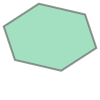

In [33]:
def get_gettis_ord_df(city, h3_col):
    gettis_ord_q = f"""
    WITH visits_per_h3 as (
    SELECT {h3_col}, CAST(SUM(raw_visit_counts) AS FLOAT64) as sum_visits
     FROM `cartodb-on-gcp-datascience.juanluis.safegraph_blackfriday_{city}` 
     WHERE raw_visit_counts > 20 
     GROUP BY {h3_col}
    )
    SELECT 
    `carto-un`.statistics.GETIS_ORD_H3(ARRAY_AGG(STRUCT({h3_col}, sum_visits)),
     5,
    'gaussian') as gettis_ord_sum,
    FROM visits_per_h3;"""
    gettis_ord_out = bq_client.query(gettis_ord_q).result().to_dataframe()
    gettis_ord_df = pd.DataFrame(data = list(gettis_ord_out.iloc[0][0]))
    gettis_ord_df["geometry"] = list(map(get_h3_pol,gettis_ord_df["index"]))
    return gettis_ord_df

get_h3_pol = lambda x : Polygon(h3.h3_to_geo_boundary(x, geo_json=True))

get_h3_pol("892664190c3ffff")

#### Getis Ord statistic


![Getis-ord](https://html.scirp.org/file/4-1880724x25.png)

Its a z-score used to locate hotspots. Takes in the value at each cell and its surroundings weighted down by a kernel. A high **gi** means that a variable is high in that cell AND in in its neighbouring cells.

We use the GETIS - ORD implementation available in CARTO's analytics toolbox:
https://docs.carto.com/analytics-toolbox-bq/sql-reference/statistics/

We run it over the sum of visits at each h3 cell at zoom level 9

```sql
    WITH visits_per_h3 as (
    SELECT h3_z9, CAST(SUM(raw_visit_counts) AS FLOAT64) as sum_visits
     FROM `cartodb-on-gcp-datascience.juanluis.safegraph_blackfriday_chicago` 
     WHERE raw_visit_counts > 20 
     GROUP BY h3_z9
    )
    SELECT 
    `carto-un`.statistics.GETIS_ORD_H3(ARRAY_AGG(STRUCT(h3_z9, sum_visits)),
     5,
    'gaussian') as gettis_ord_sum,
    FROM visits_per_h3;
```

In [52]:
gettis_ord_df = get_gettis_ord_df("chicago", "h3_z9")

After computing getis ord we need to define some general as hotspots (h3 zoom 9 cells are too small) 
- we go up two levels in h3, considering cells with zoom 7. 
- if the **gi** median of all the small cells is greater than the quantile 90% of the whole city, we consider all the big cell as a hotpot

In [57]:
%%html
<iframe height = 600, width = 100%, src = "https://public.carto.com/kuviz/70d7ba34-5707-4355-a5c1-c29e22d82518">


Cities hotspot maps for all cities:
- los_angeles https://public.carto.com/kuviz/798b45de-f874-4efd-b04f-fb23fca45dea
- chicago https://public.carto.com/kuviz/70d7ba34-5707-4355-a5c1-c29e22d82518
- buffalo https://public.carto.com/kuviz/c18ee1a3-4572-4e4d-9a3a-6e2cb1a736e9
- raleigh https://public.carto.com/kuviz/7976497a-5742-4456-9da9-be55e6201dbb


Grid Layout showing the four maps at once: ​​https://public.carto.com/kuviz/1e0a6b06-d4ae-4263-af92-8834393d1465

## 2. Selecting relevant POI categories for Black Friday

In [58]:
poi_query = f"""
SELECT top_category, count(top_category) as n , sum(raw_visit_counts) as sum_visits
FROM `cartodb-on-gcp-datascience.juanluis.safegraph_blackfriday_chicago`
WHERE raw_visit_counts is not null
GROUP BY top_category ORDER BY sum_visits DESC
"""

In [74]:
top_categories = bq_client.query(poi_query).result().to_dataframe()
top_categories["pctg"] = top_categories.n / top_categories.n.sum() * 100
top_categories["pctg_cum_sum"] = top_categories.pctg.cumsum()
print("Total number of categories = ", top_categories.shape[0])

Total number of categories =  163


In [62]:
top_categories.sum_visits = top_categories.sum_visits.astype(np.int64)
h = top_categories.head(30)
h.style.background_gradient()

,top_category,n,sum_visits,pctg,pctg_cum_sum
0,Restaurants and Other Eating Places,39580256,9085263904,19.761603,19.761603
1,"Museums, Historical Sites, and Similar Institutions",7146848,6302176832,3.568273,23.329877
2,Lessors of Real Estate,1816288,4380427120,0.906835,24.236712
3,Other Amusement and Recreation Industries,6457736,2035818168,3.224214,27.460926
4,Grocery Stores,6418728,1869822256,3.204738,30.665664
5,Elementary and Secondary Schools,5940184,1804066568,2.965811,33.631475
6,Gasoline Stations,3858944,1311385752,1.926691,35.558166
7,Religious Organizations,16036088,1224489136,8.006487,43.564653
8,Health and Personal Care Stores,5180640,1044493152,2.586586,46.151239
9,"General Merchandise Stores, including Warehouse Clubs and Supercenters",1405472,961833752,0.701723,46.852963


In [75]:
chosen_categories = [
 'Grocery Stores',
 'Clothing Stores',
 'Sporting Goods, Hobby, and Musical Instrument Stores',
 'General Merchandise Stores, including Warehouse Clubs and Supercenters',
 'Department Stores',
 'Electronics and Appliance Stores']

top_categories.set_index("top_category").loc[chosen_categories].style.background_gradient(subset  = ["pctg_cum_sum", "pctg"])

,n,sum_visits,pctg,pctg_cum_sum
top_category,,,,
Grocery Stores,6418728,1869822256,3.204738,30.665664
Clothing Stores,4054976,658334040,2.024566,55.793541
"Sporting Goods, Hobby, and Musical Instrument Stores",2917520,757354832,1.456657,53.768976
"General Merchandise Stores, including Warehouse Clubs and Supercenters",1405472,961833752,0.701723,46.852963
Department Stores,539040,600218464,0.269132,56.062673
Electronics and Appliance Stores,1714296,243627144,0.855913,69.371598


## 3. Comparing cities during Black Friday across years

For each city and year, we compute total number of visitors, and average distance from home to POIs of the selected categories falling inside the hotspot areas

#### Insights:
- Big decrease in visits in all cities during 2020 due to the pandemic. Partial recovery during 2021
- Average distance from home is higher in bigger cities. More people are willing to go to the city center to do BF shopping
- Average distance from home drops drastically on big cities during the pandemic. Not so much in smaller cities

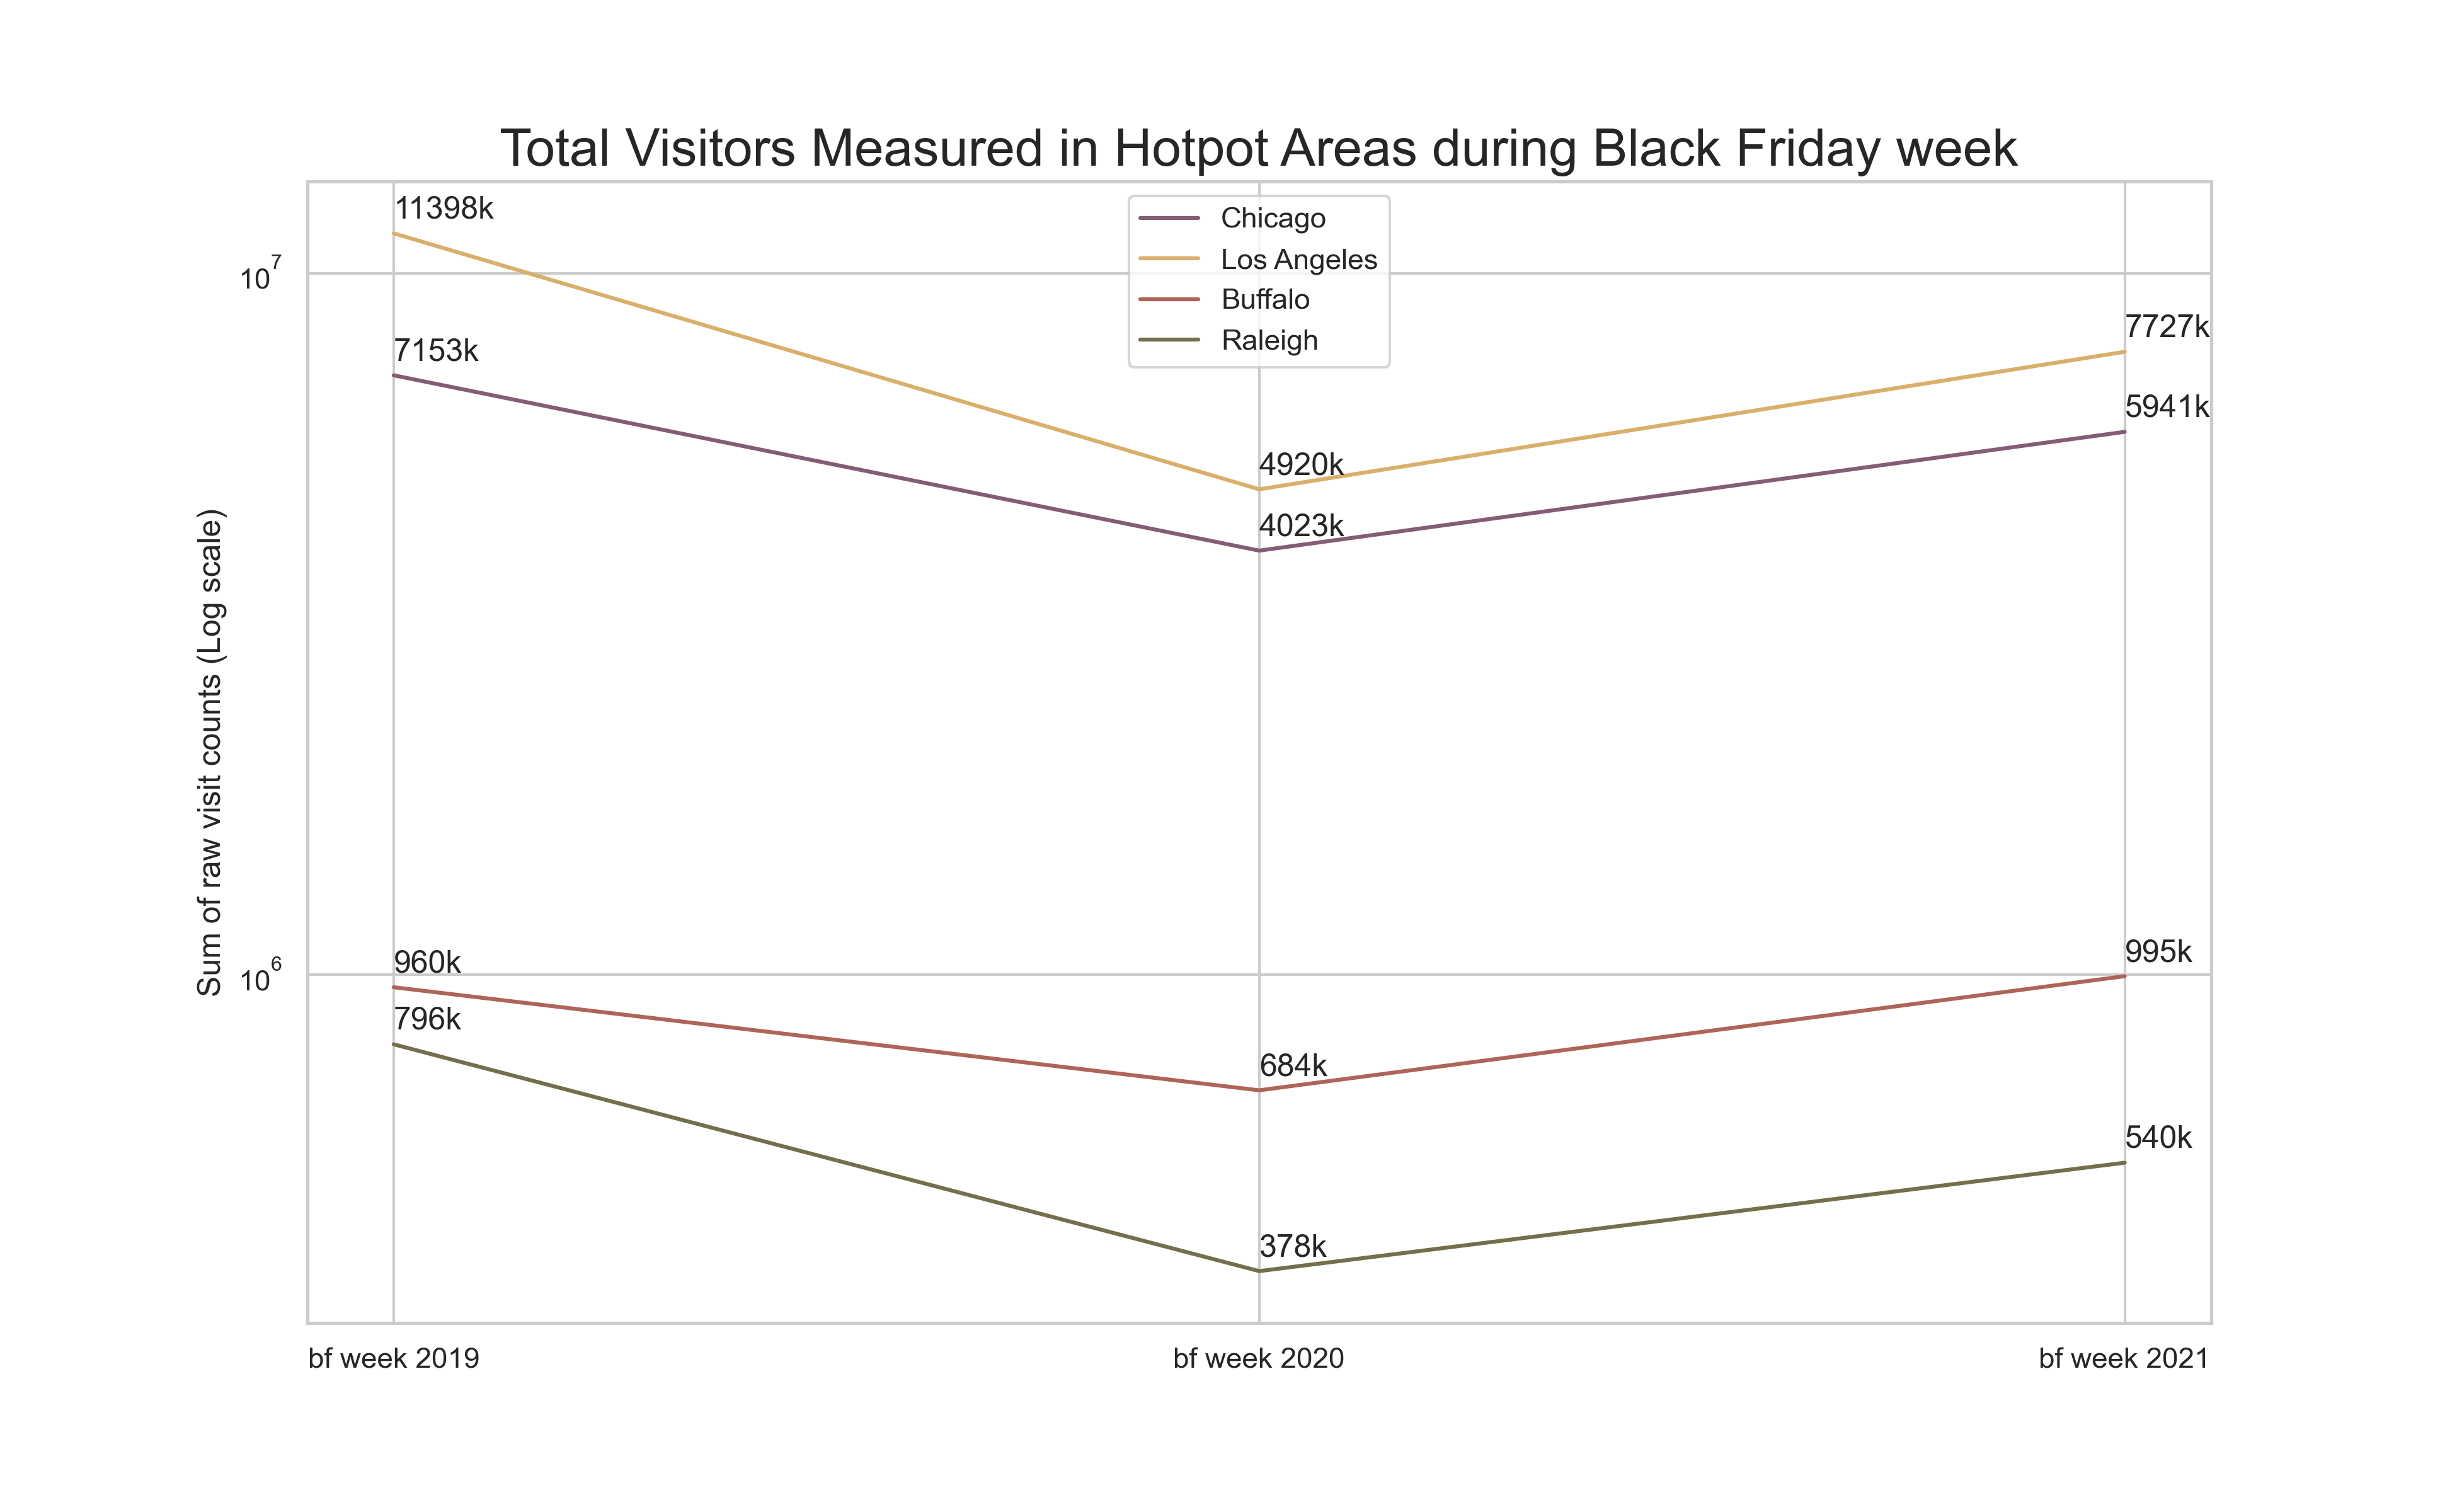

In [91]:
from PIL import Image
Image.open('pngs/sum_raw_visit_counts.png')

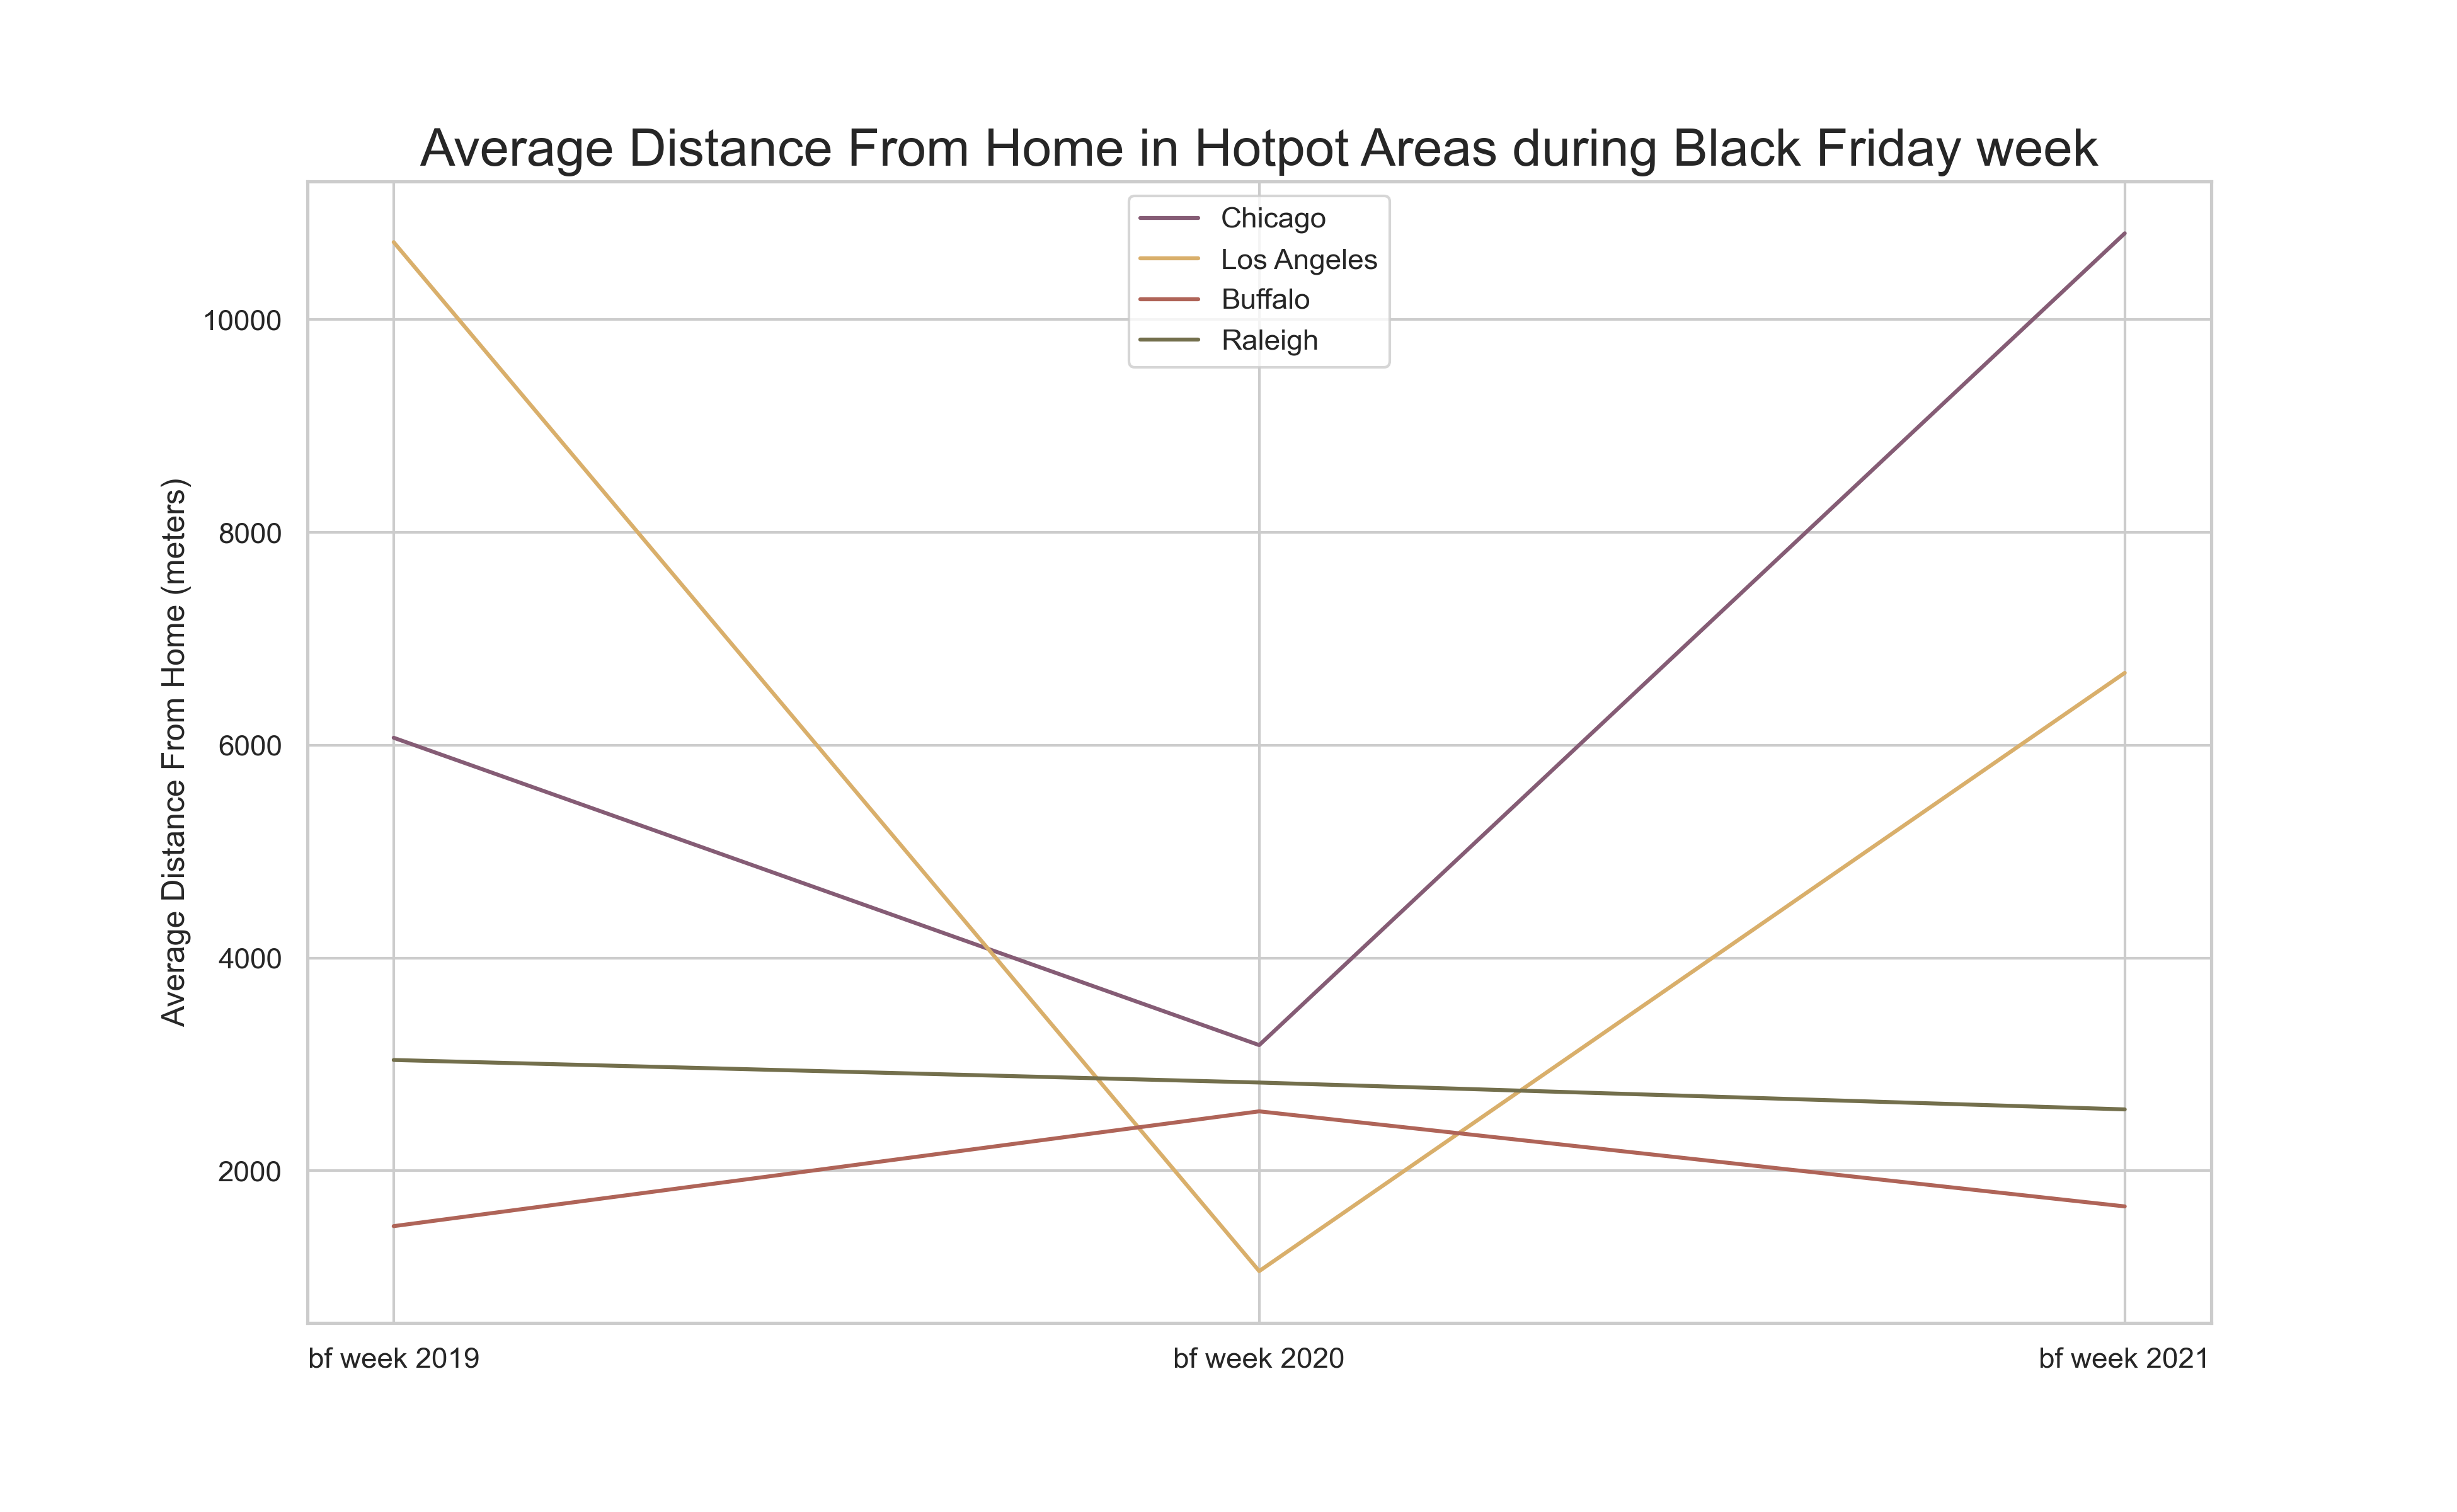

In [92]:
Image.open('pngs/avg_distance_from_home.png')

#### Chicago 2019 vs 2020 trends
- People are at home during thanksgiving
- There is a peak in Black Friday for all categories excepting grocery stores.
- In 2020, the peak during bf is smaller, excepting for sport, hobby and instrument stores.

There are other periods during the year in which much greater peaks of visits are detected for these categories: Sales / Christmas, etc...

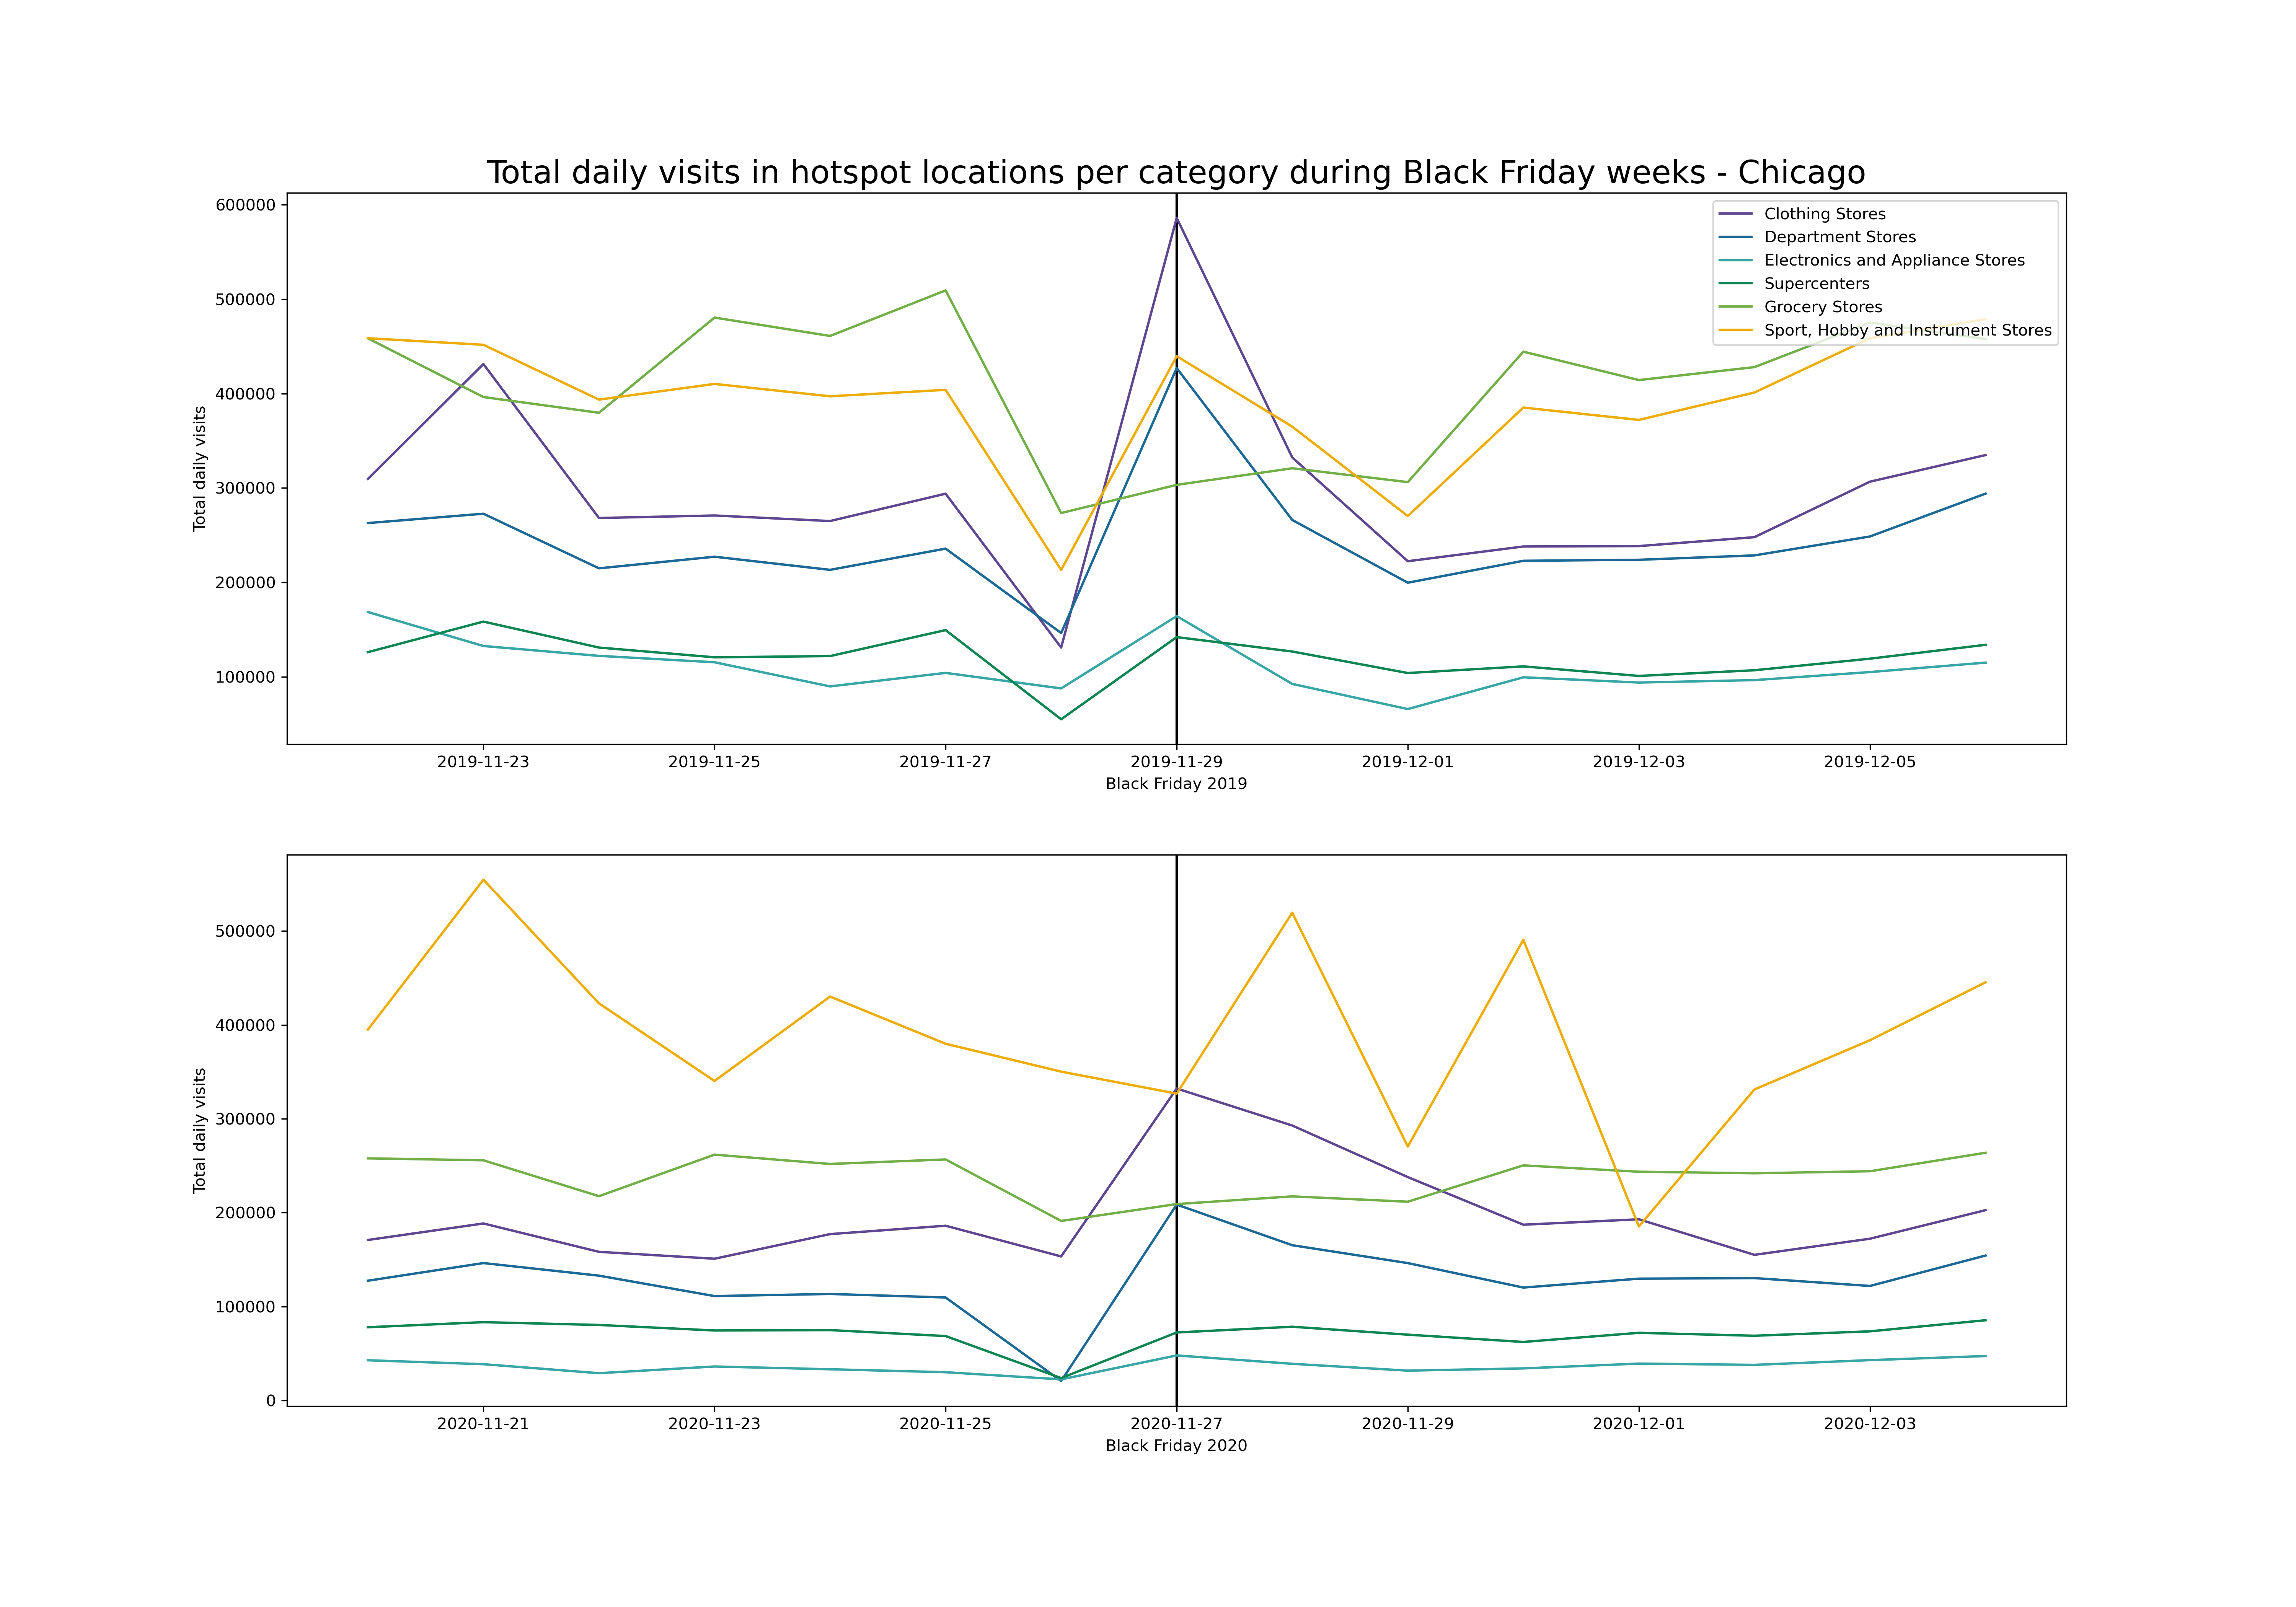

In [94]:
Image.open('pngs/visits_in_hotspots_chicago.png')

## 4. Case study: Walmart

- 16 Walmarts in Chicago
- Walmart belongs to category: 'General Merchandise Stores, including Warehouse Clubs and Supercenters',


We compute Isodistance geometries with CARTO's Isoline service through cartoframes.
Given a point and a mean of transport (car in this case), the isodistance is the geometry reachable from the starting point taking into account the terrain and road network

https://carto.com/help/working-with-data/isolines/

#### Insights
* Walmarts in the outskirts have higher average distance from home. They are visited by people in the west which have less Walmarts to choose from
* Walmarts inside the city canibalize each other since their target areas overlap
* Average distance from home slightly increases during the pandemic. Opposite as we have seen in hotspot areas (Walmarts are not in hotspot areas)
* Road network in Chicago has the shape of a grid, (isodistances have the shape of a rombus)

In [97]:
%%html
<iframe height = 600, width = 100%, src = "https://team.carto.com/u/juanluisr/kuviz/e9ee725f-acca-4072-baa8-1a8b7a156c7c">

#### Insights
- nº of visitors : 2019 > 2020 < 2021
- Walmarts in the city center have less visitors


all cities:
- Chicago: https://public.carto.com/kuviz/8de84c1f-a5ed-431a-8ba8-582ca7d39433
- Los Angeles: https://public.carto.com/kuviz/ab2bd7eb-d95d-47f9-bed9-9b2d814b53d7
- Raleigh: https://public.carto.com/kuviz/b2dd4310-2a76-49e2-b78a-31798d8f09b9 
- Buffalo: https://public.carto.com/kuviz/2dcc4b68-ff3a-4f06-ba3a-bea43e7c6f90 

In [98]:
%%html
<iframe height = 800, width = 100%, src = "https://public.carto.com/kuviz/8de84c1f-a5ed-431a-8ba8-582ca7d39433">